# Time Series in Python
# Practical approach
# Homework task

Автор: Сергеев Дмитрий

https://github.com/DmitrySerg

In [2]:
import numpy as np                               # работа с векторами и матрицами
import pandas as pd                              # таблицы и операции над данными
import matplotlib.pyplot as plt                  # графики
import seaborn as sns                            # еще графики

from dateutil.relativedelta import relativedelta # для комфортной работы с датами
from scipy.optimize import minimize              # позволяет минимизировать функции

import statsmodels.formula.api as smf            # всякая статистика и эконометрика
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # немножко функций для удобства
from tqdm import tqdm_notebook

import warnings                                  # чтобы никто не мешал бесчинствам с кодом
warnings.filterwarnings('ignore')

%matplotlib inline



from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

В этой домашней работе вам предстоит поработать с двумя временными рядами, один - уже знакомый ряд с тратой внутриигровой валюты `currency`, второй - установки по дням в одном из наших приложений, `installs`

In [3]:
currency = pd.read_csv('data/currency.csv', index_col=['Time'], parse_dates=['Time'])
installs = pd.read_csv('data/installs.csv', index_col=['Time'], parse_dates=['Time'])

In [3]:
currency.head()

,GEMS_GEMS_SPENT
Time,
2017-05-01,1199436
2017-05-02,1045515
2017-05-03,586111
2017-05-04,856601
2017-05-05,793775


In [4]:
currency.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2017-05-01 to 2018-02-24
Data columns (total 1 columns):
GEMS_GEMS_SPENT    300 non-null int64
dtypes: int64(1)
memory usage: 4.7 KB


In [5]:
installs.head()

,Users
Time,
2015-06-01,59237
2015-06-02,56541
2015-06-03,57408
2015-06-04,50956
2015-06-05,54322


In [6]:
installs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2015-06-01 to 2017-05-31
Data columns (total 1 columns):
Users    731 non-null int64
dtypes: int64(1)
memory usage: 11.4 KB


Снова посмотрим на графики временных рядов

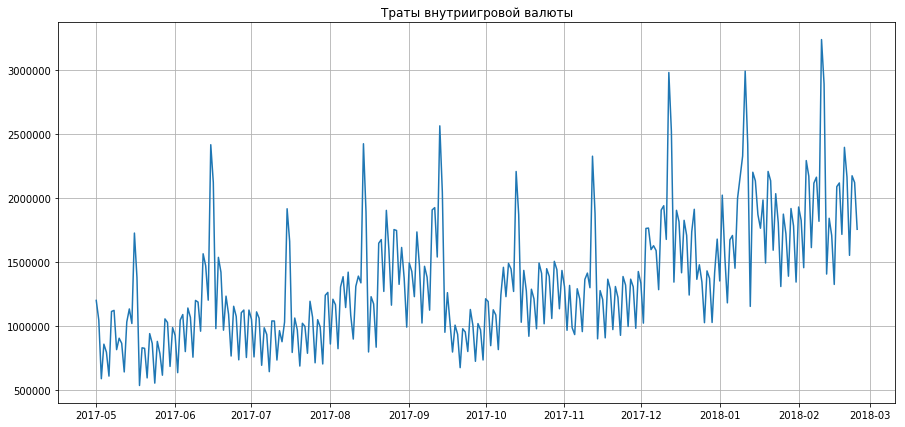

In [7]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('Траты внутриигровой валюты')
plt.grid(True)
plt.show()

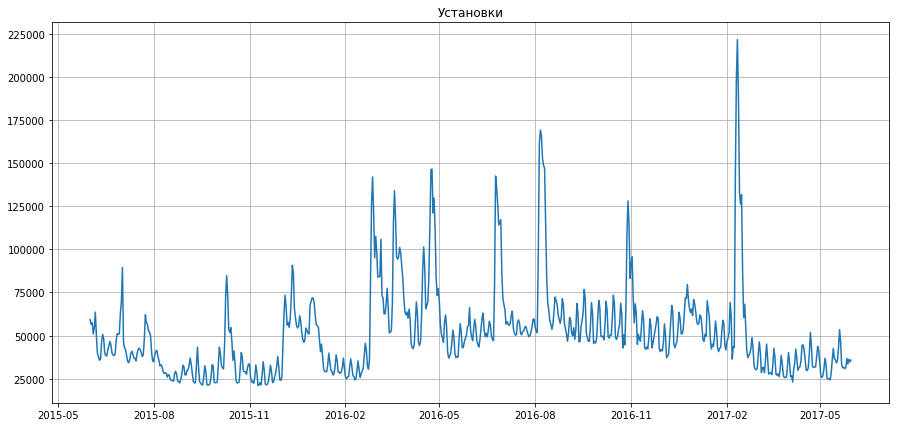

In [8]:
plt.figure(figsize=(15, 7))
plt.plot(installs)
plt.title('Установки')
plt.grid(True)
plt.show()

У первого временного ряда явно есть и сезонность, и тренд, а вот второй ряд с установками имеет очень много выбросов, которые никак не характеризуются сезонными изменениями.

Для начала поработаем с моделью тройного экспоненциального сглаживания - моделью Хольта-Винтерса

In [4]:
from sklearn.model_selection import TimeSeriesSplit 
from HoltWinters import HoltWinters                 

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # вектор ошибок
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

Задание:

- Построить модель для временного ряда с установками, используя `mean_squared_error` в качестве функции потерь
- Сначала постройте модель на всём ряду installs.Users, отложив только последние 50 наблюдений для тестирования, убедитесь, что прогноз по такой модели будет сильно заниженным
- Теперь возьмите для моделирования только последние 500 наблюдений, для этого возьмите от временного ряда срез [500:-50], чтобы учесть в модели только последние изменения и не пытаться подогнать параметры под историю, которая уже стала нерелевантной

In [32]:
%%time
data = installs.Users[:-50] # отложим 50 наблюдений для тестирования
slen = 7 # недельная сезонность
# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем квадратичную функцию потерь с ограничениями на параметры 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, 
                     mean_squared_error,
                     slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)


model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.14958909808889503 0.02648771746164602 0.1278615041821196
Wall time: 8.41 s


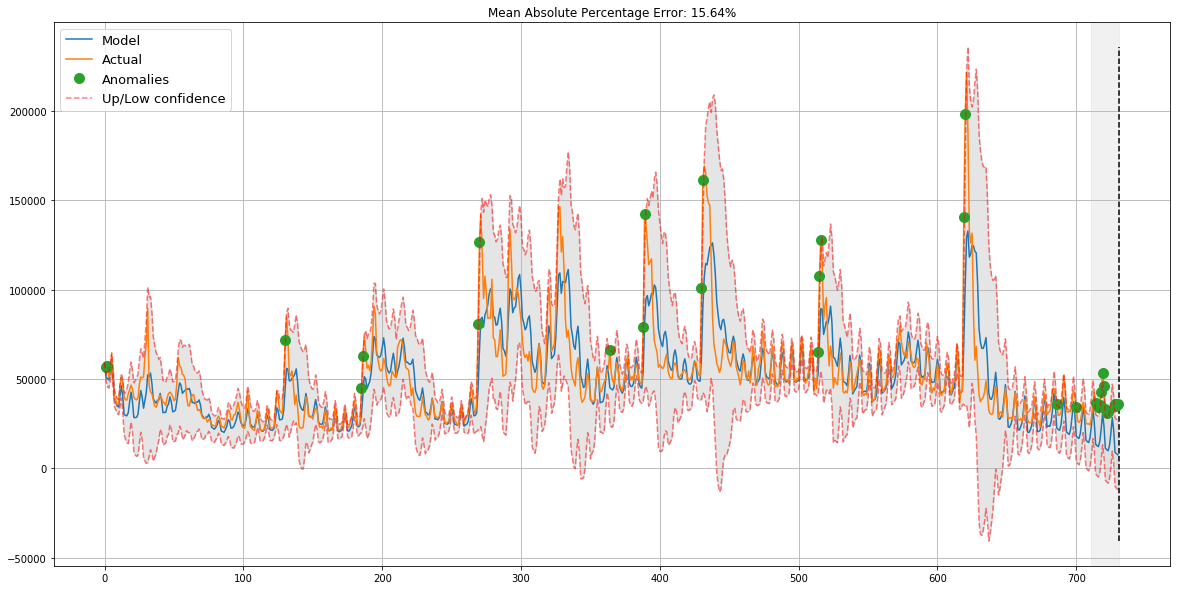

In [33]:
plotHoltWinters(installs.Users, plot_intervals=True, plot_anomalies=True)

In [59]:
def abg_search(d_start):
    data = installs.Users[d_start:-50] 
    slen = 7
    x = [0, 0, 0] 

    # Минимизируем квадратичную функцию потерь с ограничениями на параметры 
    opt = minimize(timeseriesCVscore, x0=x, 
                   args=(data, 
                         mean_squared_error, 
                         slen), 
                   method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
                  )

    # Из оптимизатора берем оптимальное значение параметров
    alpha_final, beta_final, gamma_final = opt.x
    return(gamma_final)
#    print(alpha_final, beta_final, gamma_final)

In [5]:
from tqdm import tqdm_notebook

Exception ignored in: <bound method tqdm.__del__ of  93%|██████████████████████████████████████▉   | 25/27 [12:46<01:01, 30.66s/it]>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 883, in __del__
    self.close()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 1088, in close
    self._decr_instances(self)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 452, in _decr_instances
    cls.monitor.exit()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tqdm\_monitor.py", line 50, in exit
    self.join()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


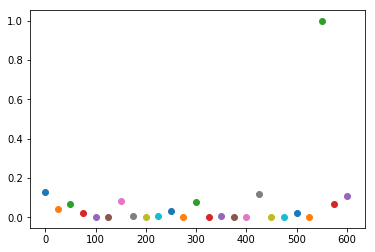

In [75]:
step=25
for i in tqdm_notebook(range(int(len(installs.Users[:-50*2])/step))):
    plt.scatter(i*step,abg_search(i*step))

А теперь обрежем наши данные, чтобы обучаться на последнем промежутке времени, наиболее релевантным для сегодняшних значений

In [76]:
%%time
data = installs.Users[500:-50] 
slen = 7
x = [0, 0, 0] 

# Минимизируем квадратичную функцию потерь с ограничениями на параметры 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, 
                     mean_squared_error, 
                     slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)


model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.2618820126194623 0.022218824066198406 0.020541629867251943
Wall time: 2.42 s


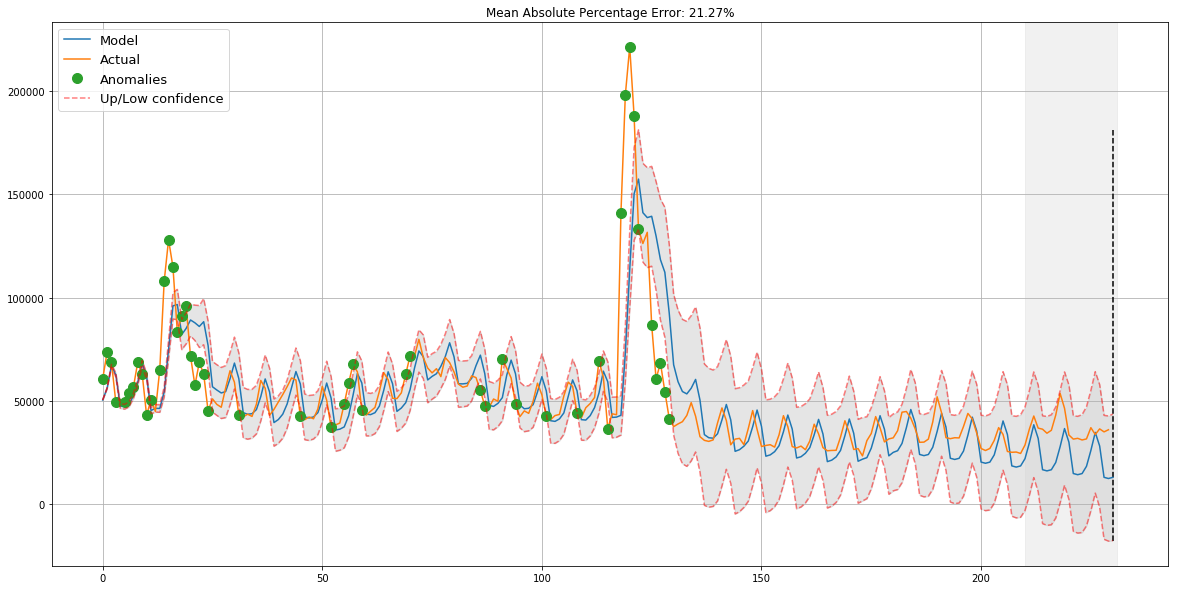

In [78]:
plotHoltWinters(installs.Users[500+1:], plot_intervals=True, plot_anomalies=True)

Прекрасно! Мы снова можем ловить аномалии, а модель неплохо описывает поведение нашего временного ряда и строит правдоподобный прогноз

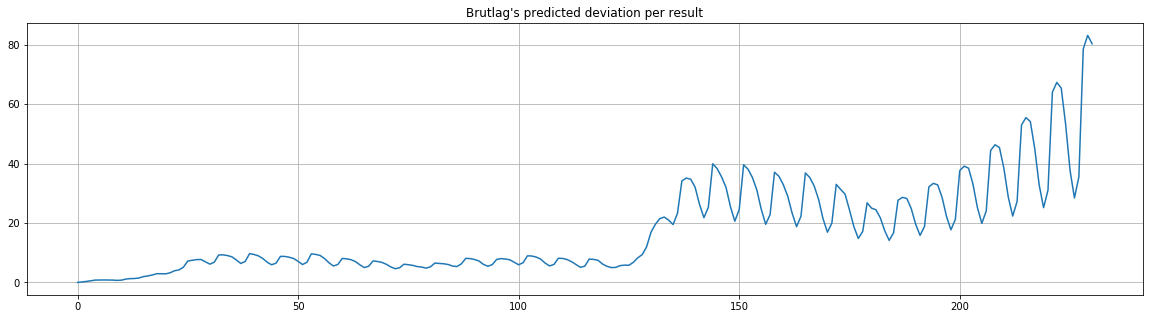

In [80]:
plt.figure(figsize=(20, 5))
d=[]
for i in range(len(model.result)):
    d.append(model.PredictedDeviation[i]/model.result[i]*100)
plt.plot(d)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation per result");

По графику смоделированной дисперсии легко увидеть, как выброс в наших данных значительно увеличил отклонение и вызвал расширение доверительных интервалов на некоторый промежуток времени

# Эконометрический подход

In [81]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])
        plt.tight_layout()

In [181]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(currency.GEMS_GEMS_SPENT, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except ValueError:
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # сортируем по возрастанию, чем меньше критерий AIC, тем лучше
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

В качестве домашнего задания и хорошей практики для закрепления - по аналогии с лекцией построить модель SARIMA для прогнозирования временного ряда с тратой внутриигровой валюты, в котором присутствует тренд (убирается при помощи первых разностей) и месячная сезонность (сезонное дифференцирование с периодом 30)

Критерий Дики-Фуллера: p=0.372542


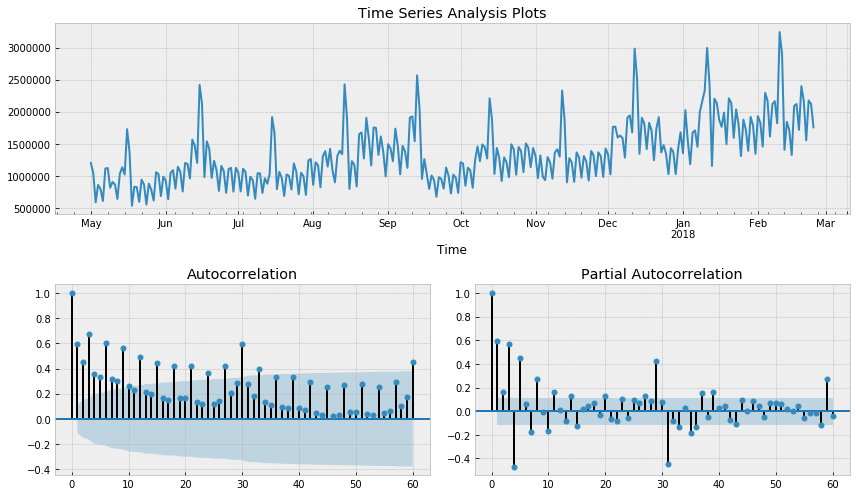

In [182]:
tsplot(currency.GEMS_GEMS_SPENT, lags=60)

# TODO
# - привести ряд к стационарному виду
# - по ACF, PACF определить начальные значения параметров модели и возможные интервалы
# - перебором параметров подобрать оптимальную модель и построить её
# - построить график модельных значений и остатков, убедиться в адекватности результатов

Критерий Дики-Фуллера: p=0.000000


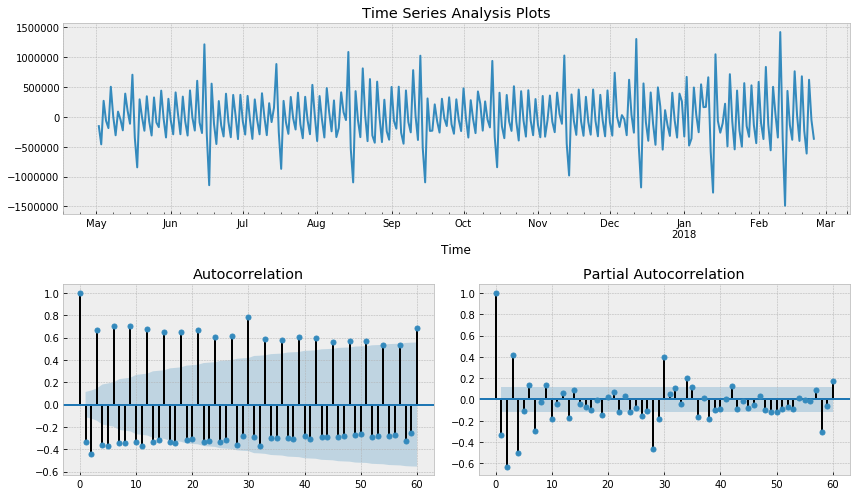

In [194]:
# Самый большой PACF при 1
f=1
df=currency.GEMS_GEMS_SPENT-currency.GEMS_GEMS_SPENT.shift(f)
tsplot(df[f:], lags=60)

Критерий Дики-Фуллера: p=0.000061


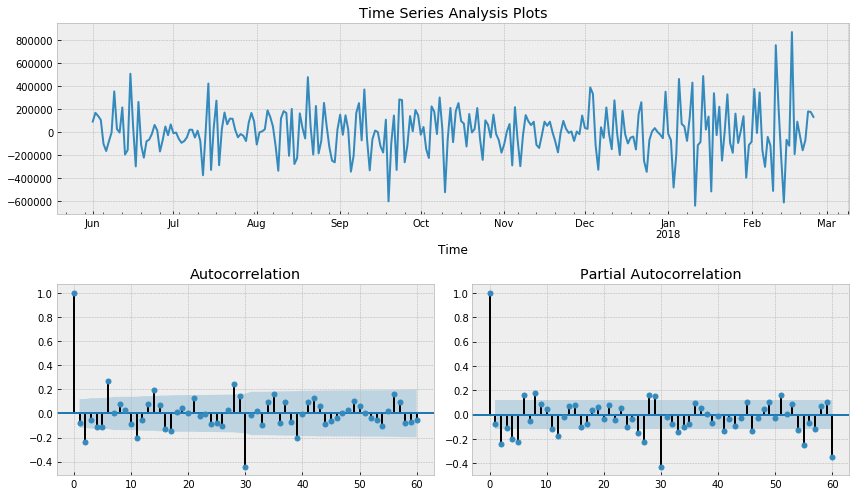

In [196]:
# Теперрь появился  p=2
f2=30
df2=df-df.shift(f2)
tsplot(df2[f+f2:], lags=60)

In [197]:
# зададим ограничения на возможные значения параметров для перебора
ps = range(1, 3) # p=1 максимальный лаг (который входит в модель авторегрессии) зависимости временного ряда от своих предыдущих значений (PACF)
d= 1 # сколько нам пришлось взять обычных разностей в ряде, чтобы привести его к стационарному
qs = range(1, 3) # q=3 лаг, с которым текущая ошибка во временном ряду зависит от предыдущих (по ACF)

Ps = range(0, 2) # 0 число значимых лагов, кратных периоду сезонности на PACF
D= 1 # либо 0, либо 1, проводилось или нет сезонное дифференцирование
Qs = range(0, 2) # 2 лаг для сезонной компоненты, с которым текущая ошибка во временном ряду зависит от предыдущих (по ACF)
s = 30 # длина сезона

# создадим лист с возможными параметрами и посчитаем его длину
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [198]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

Wall time: 42.7 s


In [199]:
result_table.parameters[0]

(1, 2, 0, 1)

In [200]:
# передаём параметры с минимальным AIC
p, q, P, Q = 5,6,1,1 #result_table.parameters[0]

# обучаем лучшую модель
best_model=sm.tsa.statespace.SARIMAX(currency.GEMS_GEMS_SPENT, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                    GEMS_GEMS_SPENT   No. Observations:                  300
Model:             SARIMAX(5, 1, 6)x(1, 1, 1, 30)   Log Likelihood               -3603.190
Date:                            Sun, 05 Aug 2018   AIC                           7234.379
Time:                                    00:55:58   BIC                           7284.705
Sample:                                05-01-2017   HQIC                          7254.590
                                     - 02-24-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5511      0.732     -0.753      0.452      -1.986       0.884
ar.L2         -0.5173      0.186   

Критерий Дики-Фуллера: p=0.000000


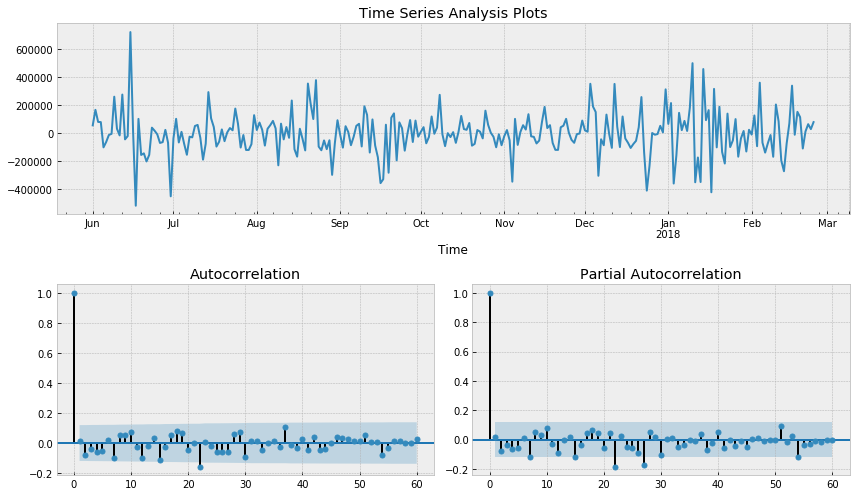

In [201]:
tsplot(best_model.resid[s+d:], lags=60)

In [202]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # подставляем модельные значения
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # делаем отступ на s+d, так как эти значения в модели были ненаблюдаемыми
    # из-за дифференцирования
    data['arima_model'][:s+d] = np.NaN
    
    # прогнозируем на n_steps шагов вперёд 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # считаем ошибку, также отступив s+d шагов от начала
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

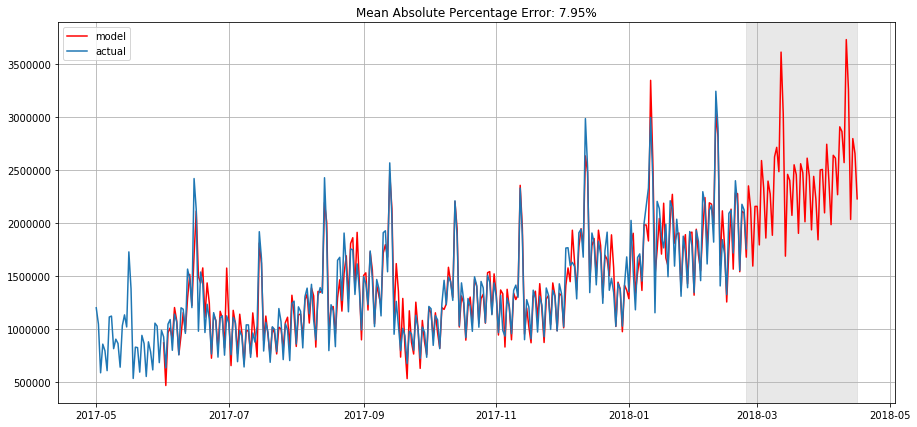

In [203]:
plotSARIMA(currency, best_model, 50)

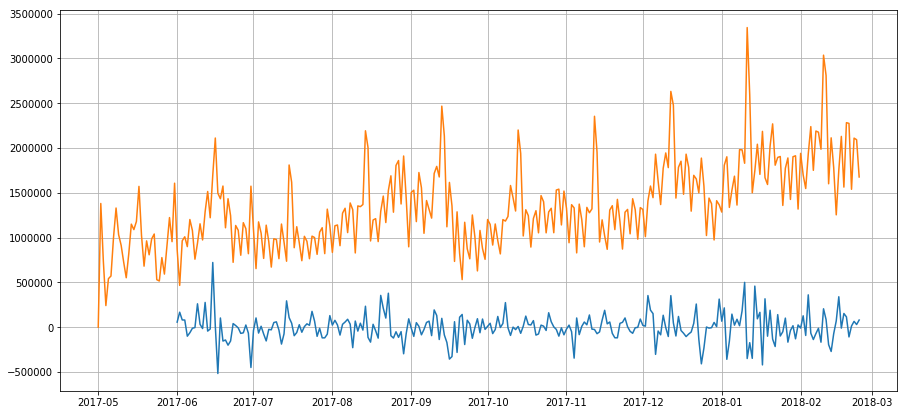

In [204]:
plt.figure(figsize=(15, 7))
plt.plot(best_model.resid[s+1:])
plt.plot(best_model.fittedvalues)
plt.grid(True)

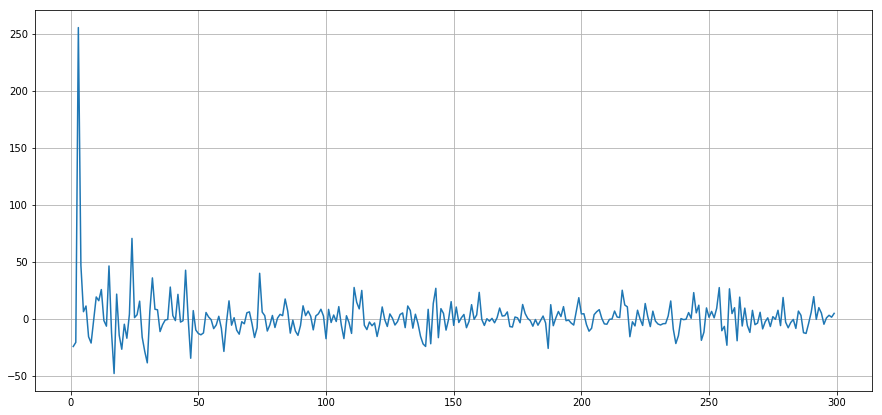

In [211]:
dlt=[]
for ii in range(len(best_model.resid)):
    dlt.append((best_model.resid.iloc[ii] / best_model.fittedvalues.iloc[ii]) * 100)
plt.figure(figsize=(15, 7))
plt.plot(dlt)
plt.grid(True)    

# Machine Learning для временных рядов

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

scaler = StandardScaler()
# для рассчета ошибки на кросс-валидации будем бить ряд на 5 фолдов
tscv = TimeSeriesSplit(n_splits=5)

In [59]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(X)*(1-test_size))
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [10]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False):
    """
    Строит график прогнозных и фактических значений, а также доверительных интервалов прогноза и аномалий
    
    """
    
    # получаем предсказания по модели
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
    Отрисовывает отсортированные по абсолютному значению коэффициенты модели
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [11]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

Снова небольшим домашним заданием будет построение моделей для временного ряда с внутриигровой валютой.

TODO

- Изменить функцию `prepareData` так, чтобы она не извлекала признак "час" и "среднее по часу", а вместо этого добавить извлечение признака "день месяца" и "среднее по дню месяца"

In [23]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # Создадим копию исходного датафрейма, чтобы можно было выполнять различные преобразования
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # Добавляем лаги целевой переменной
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # Добавляем данные по часу, дню недели и выходным
    data.index = pd.to_datetime(data.index)
    data["day"] = data.index.day
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # считаем средние только по тренировочной части, чтобы избежать лика
        test_index = int(len(data.dropna())*(1-test_size))
#        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["day_average"] = list(map(code_mean(data[:test_index], 'day', "y").get, data.day))

        # выкидываем закодированные средними признаки 
#        data.drop(["day", "weekday"], axis=1, inplace=True)
        data.drop(["day"], axis=1, inplace=True)

    # Делим на тренировочную и тестовую
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

- Подготовить данные для построения модели, взяв `lag_start = 7`, чтобы модель могла прогнозировать на неделю вперед, а `lag_end = 31`, чтобы месячная сезонность также попала в наблюдаемые моделью значения
- Построить линейную модель с `target_encoding` (среднее по дню месяца) и без, проверить, что лучше

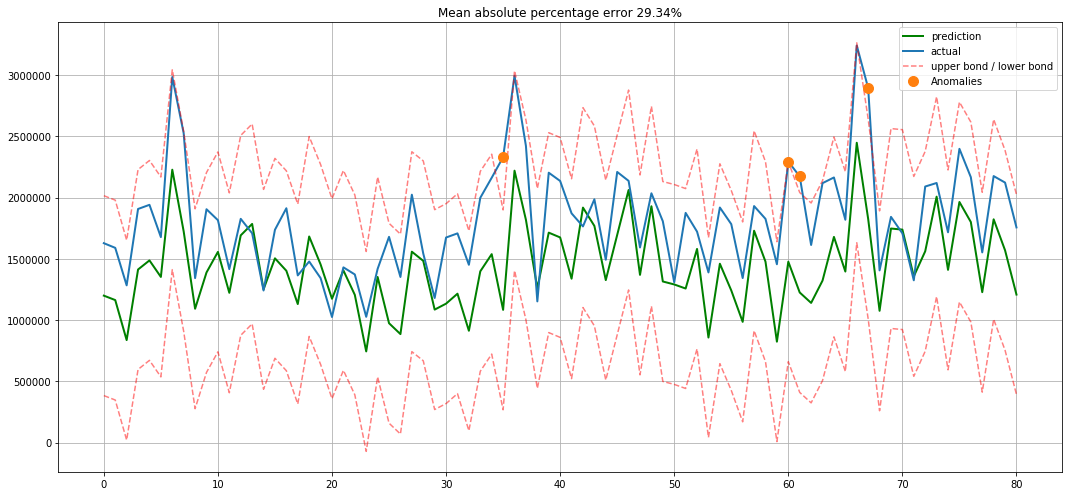

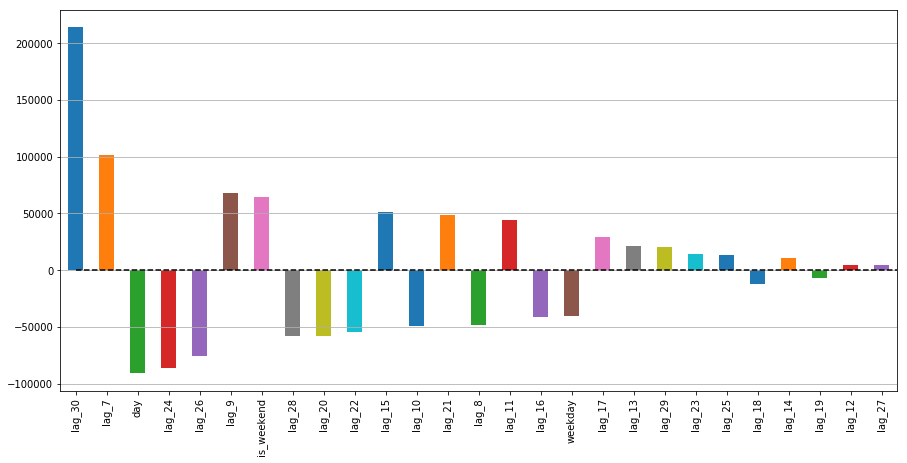

In [24]:
X_train, X_test, y_train, y_test =\
    prepareData(currency.GEMS_GEMS_SPENT, lag_start=7, lag_end=31, test_size=0.3, target_encoding=False)

# Нормируем
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# учим регрессию
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

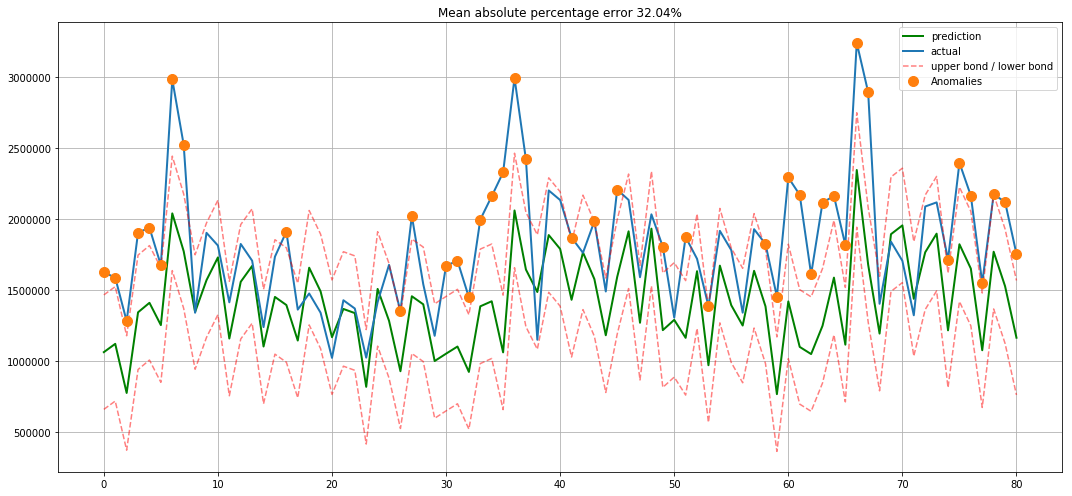

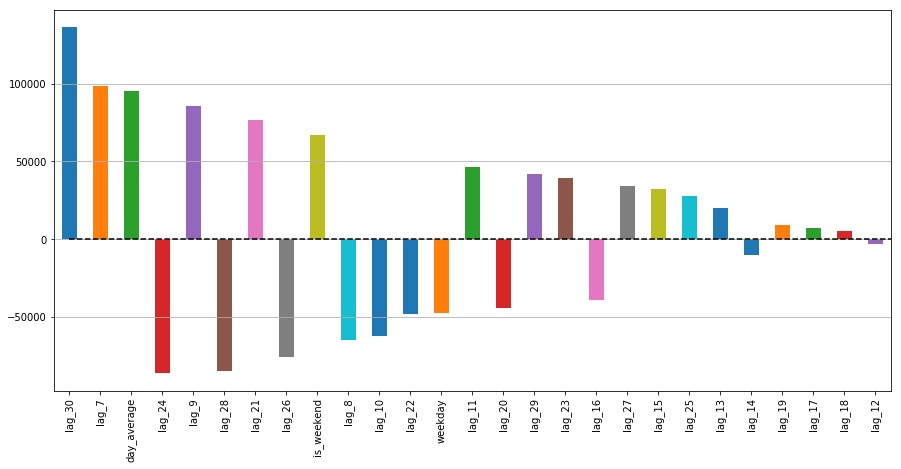

In [25]:
X_train, X_test, y_train, y_test =\
    prepareData(currency.GEMS_GEMS_SPENT, lag_start=7, lag_end=31, test_size=0.3, target_encoding=True)

# Нормируем
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# учим регрессию
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

- Построить ридж и лассо регрессии, посмотреть, какие факторы модели считают наиболее важными

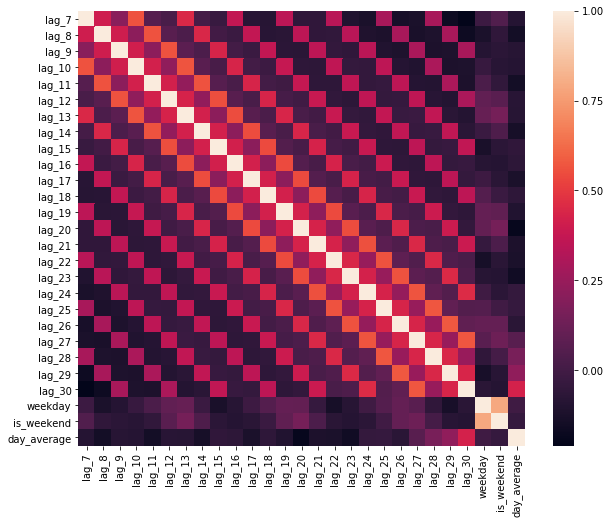

In [27]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

In [28]:
from sklearn.linear_model import LassoCV, RidgeCV

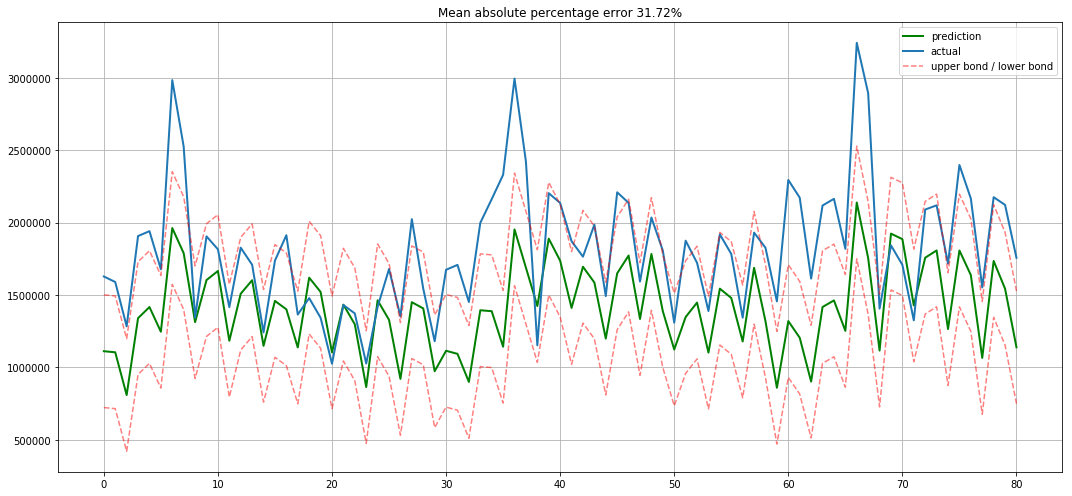

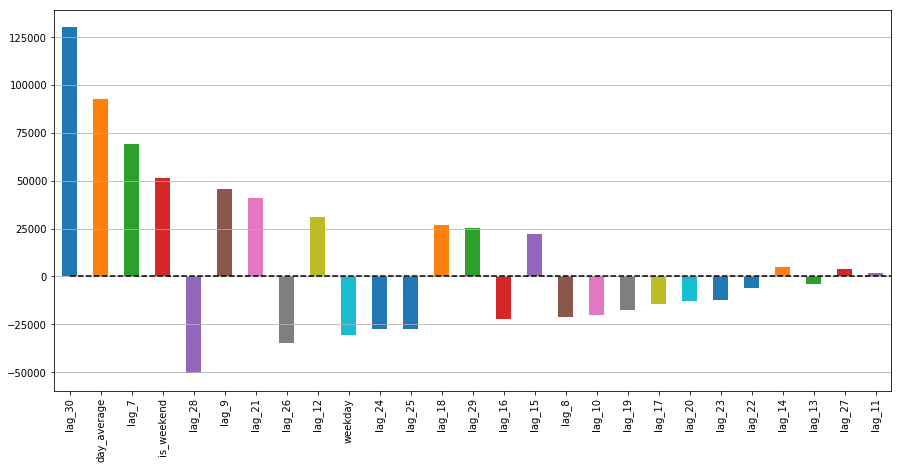

In [29]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True)
plotCoefficients(ridge)

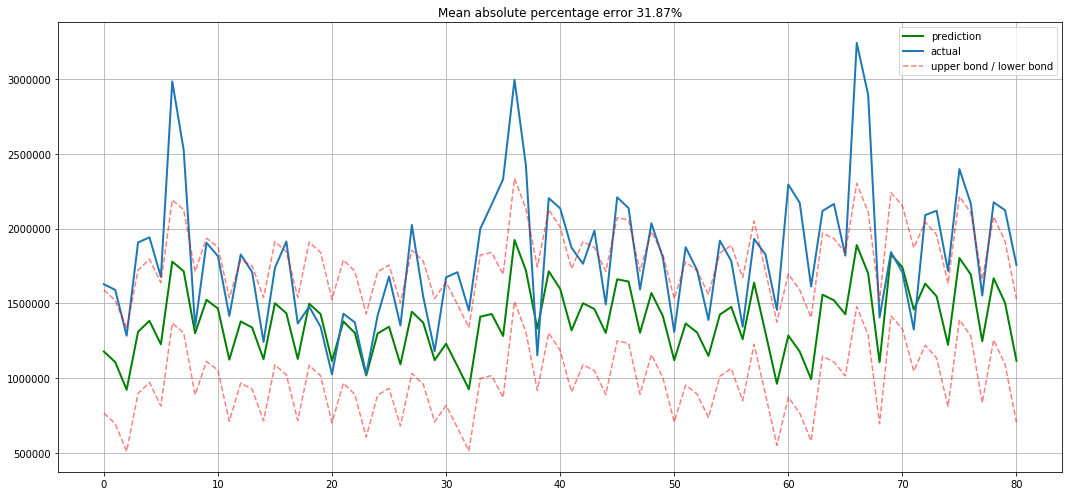

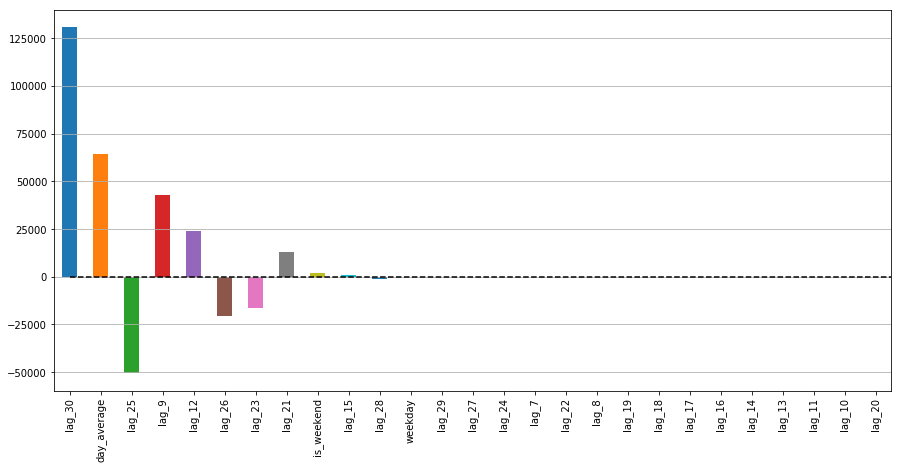

In [30]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True)
plotCoefficients(lasso)

In [35]:
# лассо почистил капитально. При этом ошибка лучше, чем на всех фичах, но чуть хуже, чем на righe

- Забустить этот временной ряд и убедиться, что по умолчанию `xgb` будет давать отвратительный результат

In [32]:
from xgboost import XGBRegressor 

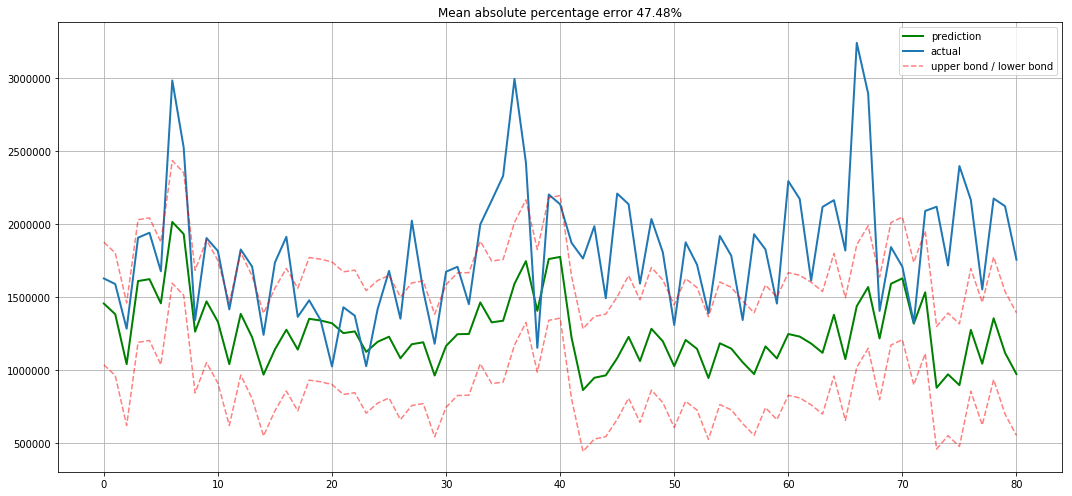

In [33]:
xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True)

In [34]:
# убедились ))) и впрямь -  не айс


Крутое бонус-задание
- Разбейте подготовленные данные на `train` и `test`

In [65]:
from sklearn.linear_model import LinearRegression

In [223]:
X=pd.DataFrame(columns=['X','y'])
X.X=[x for x in range(len(currency))]
X.y=currency.GEMS_GEMS_SPENT.values

In [224]:
train_len=int(0.7*len(currency))
train=X[:train_len]
test=X[train_len:]

In [225]:
X_train=train.drop('y', axis=1)
X_test=test.drop('y', axis=1)
y_train=train.drop('X', axis=1)
y_test=test.drop('X', axis=1)

- Очистите временной ряд от линейного тренда при помощи построения однофакторной линейной регрессии, где таргетом будут значения ряда, а фактором - числовой ряд от 0 до `len(train)`. Предсказанные по такой модели значения будут линейным трендом, который нужно вычесть из исходного ряда (подбробнее можно посмотреть [здесь](https://machinelearningmastery.com/time-series-trends-in-python/))

In [226]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

- Теперь спрогнозируйте значения тренда по этой модели для тестового датасета, для этого нужно в качестве фактора взять числовой ряд от `len(train)` до `len(test)`, очистите тестовый датасет от тренда при помощи этого прогноза

In [227]:
trend = model.predict(X_test)

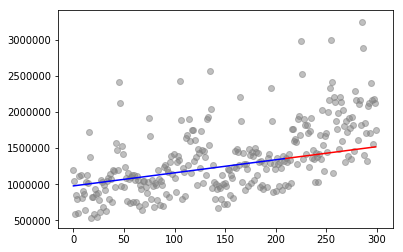

In [228]:
plt.scatter(X_train, y_train, color='grey', alpha=0.5)
plt.scatter(X_test, y_test, color='grey', alpha=0.5)
plt.plot(model.predict(X_train), color='blue')
plt.plot(X_test, trend, color='red')

In [229]:
X['trend']=model.predict(X.drop('y', axis=1))

In [230]:
X.head()

,X,y,trend
0,0,1199436,977062.935184
1,1,1045515,978872.675335
2,2,586111,980682.415486
3,3,856601,982492.155637
4,4,793775,984301.895788


In [231]:
X['y_no_trend']=X.y-X.trend

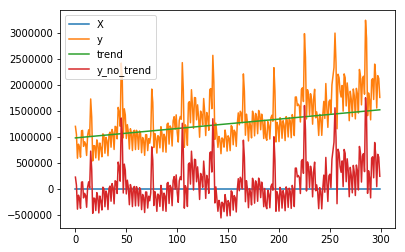

In [232]:
X.plot()


- Далее на очищенных от тренда данных `train` постройте xgboost и постройте прогноз на `test`

In [360]:
X_no_trend=X.drop(['y', 'trend'], axis=1)

In [361]:
X_new=currency.copy()

In [362]:
X_new.GEMS_GEMS_SPENT=X_no_trend.y_no_trend.values

In [363]:
X_train, X_test, y_train, y_test =\
    prepareData(X_new.GEMS_GEMS_SPENT, lag_start=7, lag_end=31, test_size=0.3, target_encoding=True)

In [364]:
# Нормируем
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [365]:
# учим буст
xgb = XGBRegressor()
model=xgb
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

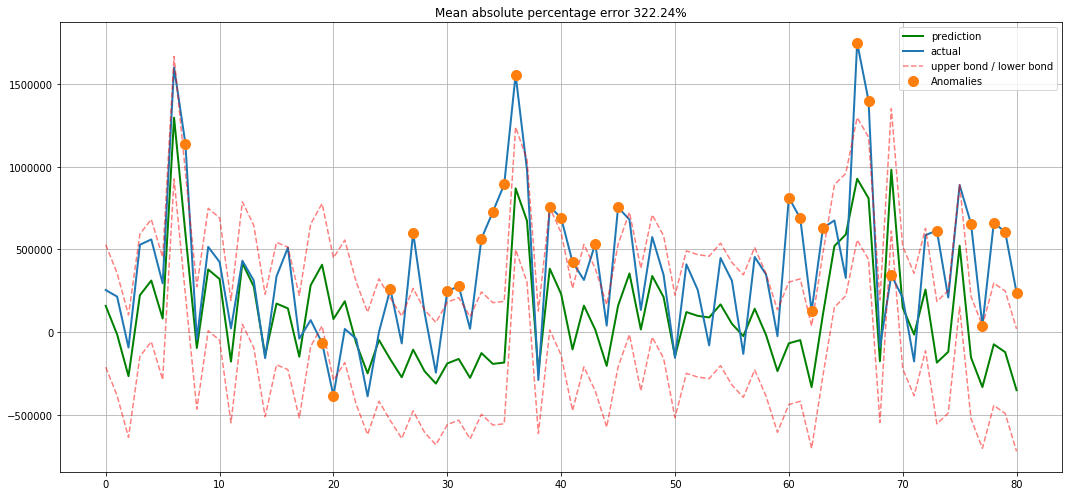

In [366]:
plotModelResults(xgb, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)

- Наконец, просуммируйте предсказанное значение тренда и прогнозы бустинга, чтобы получить красивый итоговый прогноз временного ряда

In [367]:
X_full=np.vstack([X_train_scaled, X_test_scaled])
y_full=np.vstack([y_train.values.reshape((-1, 1)), y_test.values.reshape((-1, 1))])

In [369]:
y_full_wt=y_full+X.trend.values.reshape((-1, 1))[:270]

In [368]:
prediction = (model.predict(X_full)+X.trend[:270]).values.reshape((-1, 1))

In [407]:
l=len(X_train_scaled)
error = mean_absolute_percentage_error(prediction[l:], y_full_wt[l:])

cv = cross_val_score(model, X_full, y_full, 
                            cv=tscv, 
                            scoring="neg_mean_absolute_error")
mae = cv.mean() * (-1)
deviation = cv.std()

scale = 1.96
lower = prediction - (mae + scale * deviation)
upper = prediction + (mae + scale * deviation)

anomalies = np.array([np.NaN]*len(y_full_wt)).reshape((-1,1))
anomalies[y_full_wt<lower] =  y_full_wt[y_full_wt<lower]
anomalies[y_full_wt>upper]= y_full_wt[y_full_wt>upper]

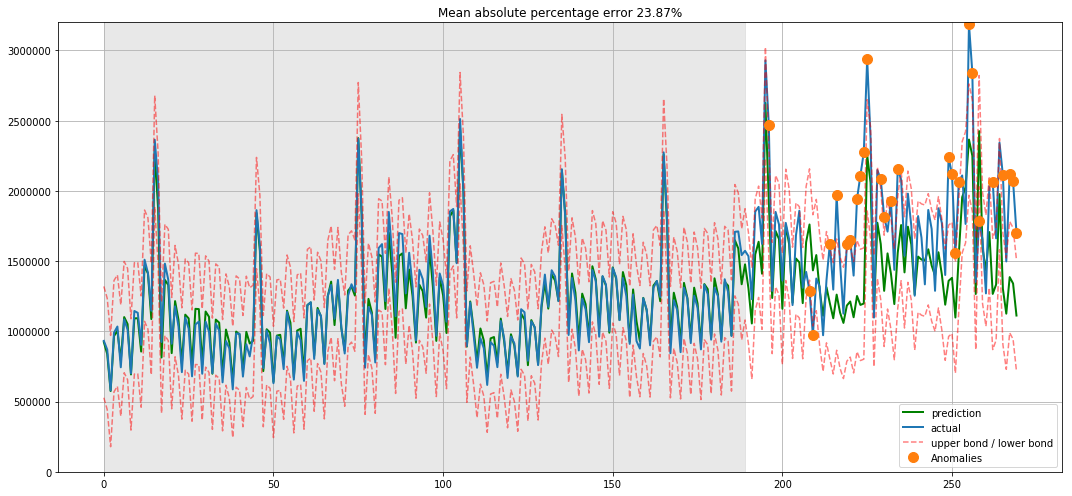

In [409]:
plt.figure(figsize=(15, 7))

plt.title("Mean absolute percentage error {0:.2f}%".format(error))

plt.plot(prediction, "g", label="prediction", linewidth=2.0)
plt.plot(y_full_wt, label="actual", linewidth=2.0)

plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
plt.plot(upper, "r--", alpha=0.5)
plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

plt.ylim(0,3200000)
plt.axvspan(0, l, alpha=0.5, color='lightgrey')
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True);

## А не обратиться ли нам к FB нашему Prophet?!

In [39]:
from fbprophet import Prophet

In [43]:
# создаем специфический датасет, с определенными названиями столбцов. В "ds" должно быть datetime, в "y" - значения таргета
df = currency.reset_index()
df.columns = ['ds', 'y']
predictions = 60 # задаем число предсказаний будущих значений
train_df = df[:-predictions] # откладываем часть данных для тестирования

# обучаем модель, обязательно указывая тип сезонности, который хотим использовать
model = Prophet(weekly_seasonality=True, daily_seasonality=False)
model.fit(train_df)

# создаем еще один специфический датафрейм, который нужен для предсказаний
# здесь нужно указать частоту данных (по умолчанию - дни)
future = model.make_future_dataframe(periods=predictions, freq='H')

# делаем предсказания 
forecast = model.predict(future)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [46]:
error = mean_absolute_percentage_error(df[-predictions:]['y'], forecast[-predictions:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))

Mean absolute percentage error 22.20%


In [48]:
# Модель пока лучше всех предыдущих (по Mean absolute percentage error)

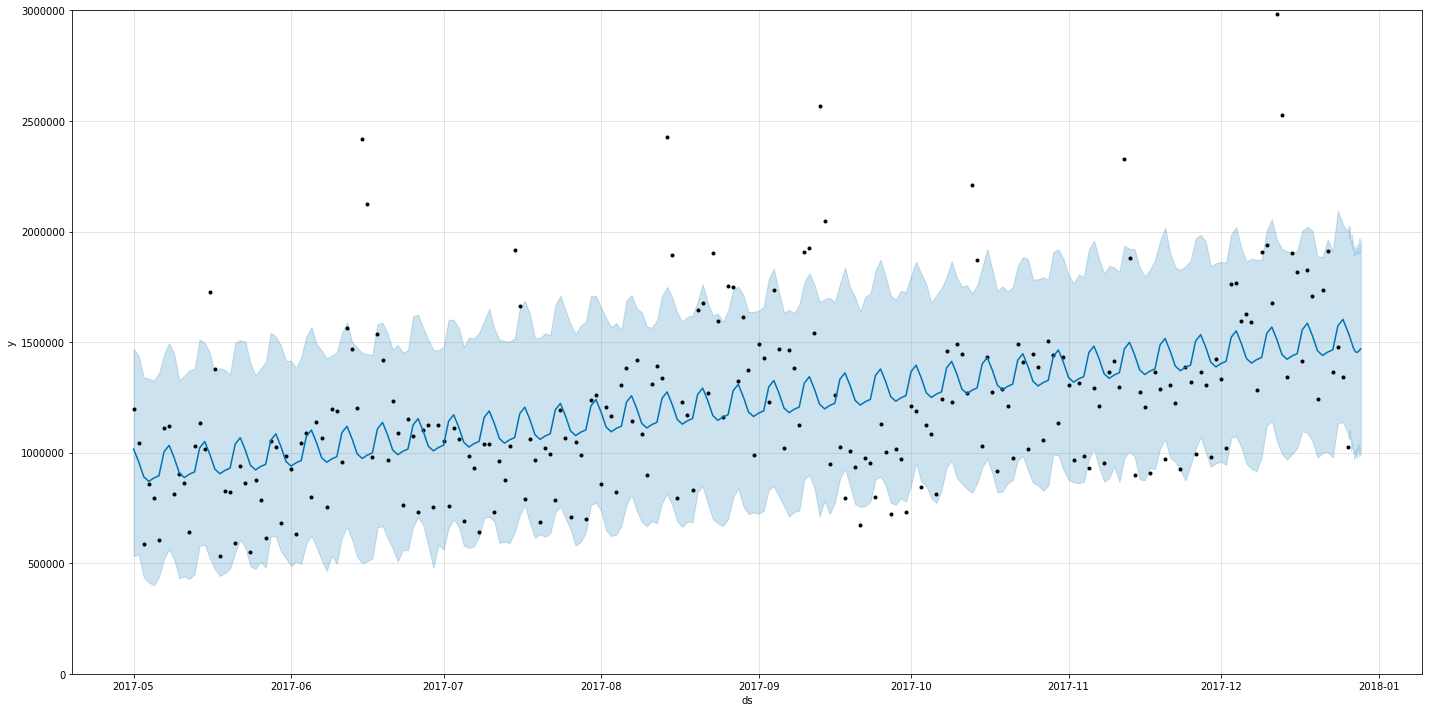

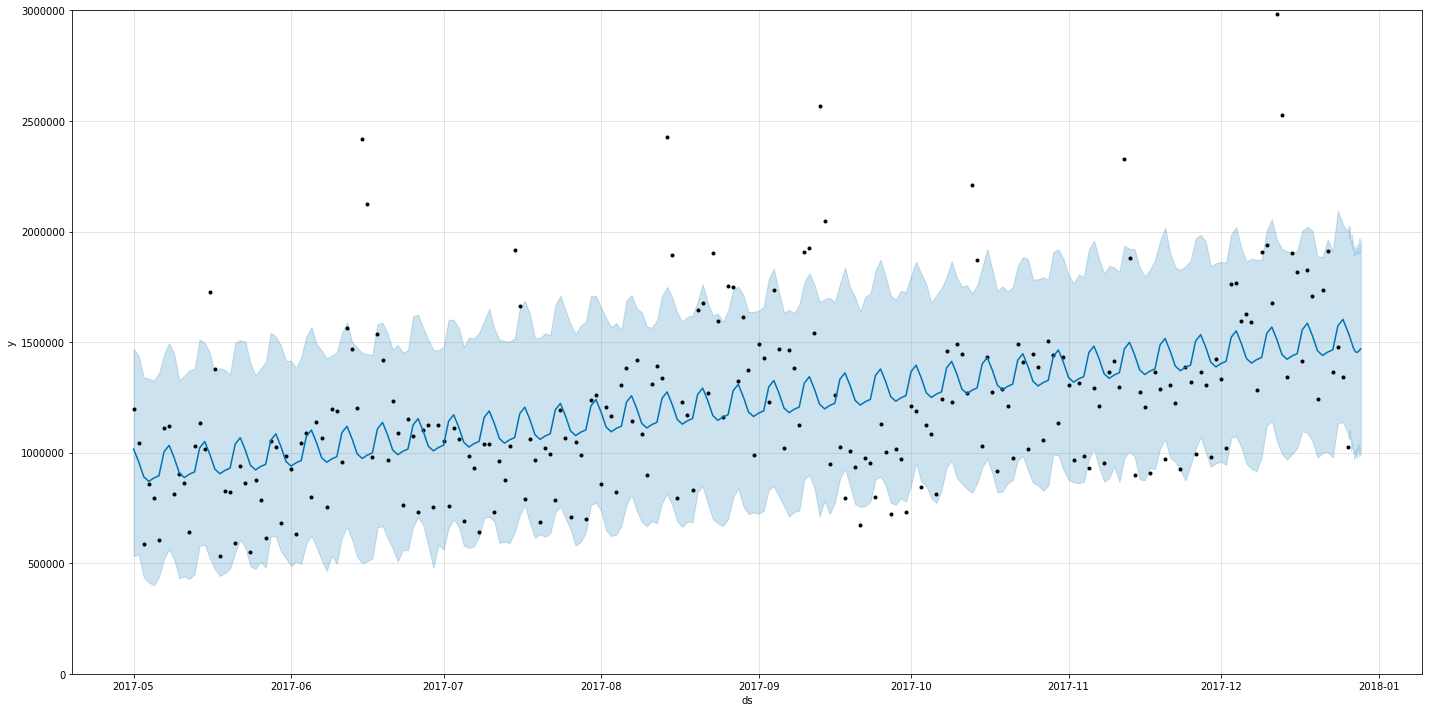

In [50]:
# рисуем предсказания
_, ax = plt.subplots(figsize=(20,10))
ax.set_ylim(0, 3000000)
model.plot(forecast, ax)

# ??? хотя визуализация как-то совсем не впечатляет.. огромный разброс и предсказание совсем не клеится с точками.. просто тренд+средняя неделя.. почему тогда ошибка меньше?

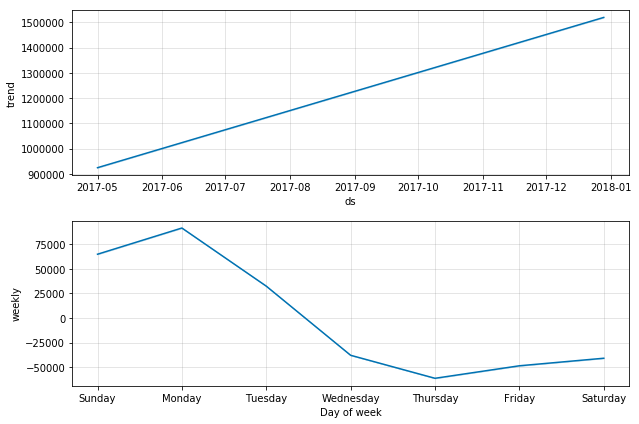

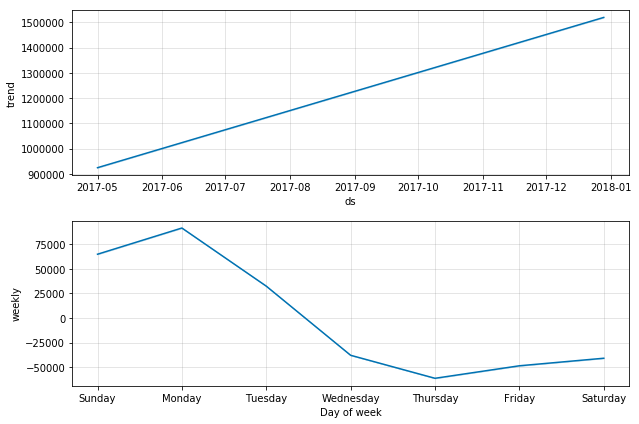

In [58]:
# смотрим компоненты предсказания
model.plot_components(forecast) 